<a href="https://colab.research.google.com/github/unna97/fastai/blob/master/Major_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#all the imports
import matplotlib.pyplot as plot
import pandas as pd
#from pydub import AudioSegment
import IPython
#import soundfile as sf
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

##Data Wrangling

In [0]:
#the dataset of audio file:
#download dataset function
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")


####download dataset and read dataset
reference 
1. https://medium.com/@Keshav31/colab-features-download-and-upload-e1ec537a83df
2. https://github.com/karoldvl/ESC-50

In [3]:
download('https://github.com/karoldvl/ESC-50/archive/master.zip','envsound.zip')
print("All the files are downloaded")

All the files are downloaded


##### create the right directory and store in that


In [4]:
!mkdir '/content/env_sound'
!cp '/content/envsound.zip' '/content/env_sound/'

mkdir: cannot create directory ‘/content/env_sound’: File exists


In [0]:
!rm '/content/envsound.zip'

In [0]:
!mkdir '/content/output'
!mkdir '/content/output/Filbank'
!mkdir '/content/output/MFCC'

#####unzip the file

syntax-  !unzip filename.zip -d path/to/extract/to

In [6]:
!unzip '/content/env_sound/envsound.zip' -d '/content/env_sound/'

Archive:  /content/env_sound/envsound.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/env_sound/envsound.zip or
        /content/env_sound/envsound.zip.zip, and cannot find /content/env_sound/envsound.zip.ZIP, period.


In [0]:
!ls '/content/env_sound/ESC-50-master/audio' 

#####master path

In [0]:
path = '/content/env_sound/ESC-50-master/audio/'
p='/content/env_sound/ESC-50-master/meta/esc50.csv'

In [0]:
data=pd.read_csv(p)
data.head()

In [10]:
#using path + data.filename[index]=audio location
#IPython.display.Audio(path+data.filename[0])
dogs=data.index[data.category=='dog']
IPython.display.Audio(path+data.filename[dogs[3]] )



####Conversion of sound to images for CNN

#####1.pre-emphasis filter


In [0]:
index=1
def conversion(index):
  #read the file
  sample_rate, signal = scipy.io.wavfile.read(path+data.filename[index])
  T = signal.shape[0] / float(sample_rate)
  t = np.arange(signal.shape[0]) / float(sample_rate)
  #apply the preemphasis
  pre_emphasis = 0.97
  emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  #Framing:
  frame_size=0.025
  frame_stride=0.01
  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]
  #Window
  frames *= np.hamming(frame_length)
  #Fourier Transform
  NFFT=512
  mag_frames = np.absolute(np.fft.rfft(frames, NFFT)) 
  #Power SPectrum
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
  #filterBanks
  nfilt = 40
  low_freq_mel = 0
  high_freq_mel = (2595.0 * np.log10(1.0 + (sample_rate / 2.0) / 700.0))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700.0 * (10.0 ** (mel_points / 2595.0) - 1.0))  # Convert Mel to Hz
  bin = np.floor((NFFT + 1) * hz_points / sample_rate)  # FFT bins

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for j in range(0,nfilt):  # Loop over filters
      for i in range(int(bin[j]), int(bin[j + 1])):  # positive side
          fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
      for i in range(int(bin[j + 1]), int(bin[j + 2])):  # negative side
          fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
   
  
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) # Numerical Stability
  filter_banks = 20 * np.log10(filter_banks)  # dB
  #MFCC
  numceps = 13
  mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : numceps]
  #Mean Normalization
  filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
  mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
  #plot and save
  plot.imshow(np.flipud(filter_banks.T), cmap=plot.cm.jet, aspect=0.2, extent=[0,T,0,4])
  plot.savefig('/content/output/Filbank/'+str(index)+'.jpg', bbox_inches='tight', dpi=200)
  plot.imshow(np.flipud(mfcc.T), cmap=plot.cm.jet, aspect=0.08, extent=[0,T,1,numceps])
  plot.savefig('/content/output/Filbank/'+str(index)+'.jpg', bbox_inches='tight', dpi=200)
  


KeyboardInterrupt: ignored

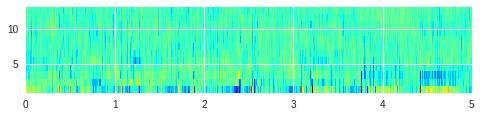

In [118]:
# for i in range(len(data)):
#   conversion(i)
plot.savefig(''+str(index)+'.jpg', bbox_inches='tight', dpi=200)

#####2.Framing
frame_size is set to be 0.025
frame_stride=0.01
overlap=0.015

In [123]:
# from google.colab import files
# files.download('/content/output/Filbank/0.jpg')
!zip /content/output/Filbank


zip error: Nothing to do! (/content/output/Filbank.zip)


In [102]:
len(data)

2000

#####3.Window 
Function used is Hamming


#####4.Fourier Transform
NFFT=512

#####5.PowerSpectrum

In [0]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

#####6.FilterBanks

#####7.MFCC

#####8.Mean Normalization

In [0]:

#filter_banks -= (np.mean(filter_banks, axis=0) + np.finfo(float).eps)
#np.finfo(float).eps
  

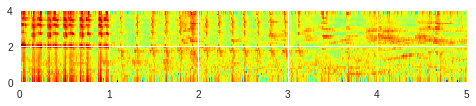

In [84]:

#plot.show

